# Test learner

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from fastai import *
from fastai.vision import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile
from pathlib import Path

import torchvision
from efficientnet_pytorch import EfficientNet
from torchvision.models import vgg16_bn

In [2]:
def get_DIV2k_data(pLow, bs:int, sz:int):
    """Given the path of low resolution images with a proper suffix
       returns a databunch
    """
    suffixes = {"dataset/DIV2K_train_LR_x8": "x8",
                "dataset/DIV2K_train_LR_difficult":"x4d", 
                "dataset/DIV2K_train_LR_mild":"x4m"}
    lowResSuffix = suffixes[str(pLow)]
    src = ImageImageList.from_folder(pLow).split_by_idxs(train_idx=list(range(0,800)), valid_idx=list(range(800,900)))
    
    data = (src.label_from_func(lambda x: path_fullRes/(x.name).replace(lowResSuffix, '')).transform(
            get_transforms(
                flip_vert=True,
                max_rotate=30,
                max_zoom=3.,
                max_lighting=.4,
                max_warp=.4,
                p_affine=.85
            ),
            size=sz,
            tfm_y=True,
        ).databunch(bs=bs, num_workers=8, no_check=True).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [3]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'
path_lowRes_diff = path/'DIV2K_train_LR_difficult' # suffix "x4d" ~300px
path_lowRes_mild = path/'DIV2K_train_LR_mild' # suffix "x4m" ~300px
path_lowRes_x8 = path/'DIV2K_train_LR_x8' # suffix "x8" ~150px


proj_id = 'unet_superRes_mobileNet_FeatSSIM'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [4]:
model = geffnet.mobilenetv3_100
# model = models.resnet34
# model= geffnet.tf_efficientnet_b4

In [5]:
# loss_func = FeatureLoss()
loss_func = msssim
# loss_func = calculate_frechet_distance

In [6]:
bs=20
sz=512
lr = 1e-2
wd = 1e-3
epochs = 5

In [7]:
data_gen = get_DIV2k_data(path_lowRes_diff, bs=bs, sz=sz)

In [8]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [9]:
learn_gen.load("unet_superRes_mobileNet_FeatSSIM_gen_512px_1")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_difficult;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_difficult;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(

In [10]:
fn = data_gen.; fn

PosixPath('dataset/DIV2K_train_LR_difficult/0848x4d.png')

In [11]:
img = open_image(fn); img.shape

torch.Size([3, 384, 510])

In [12]:
p,img_hr,b = learn_gen.predict(img)

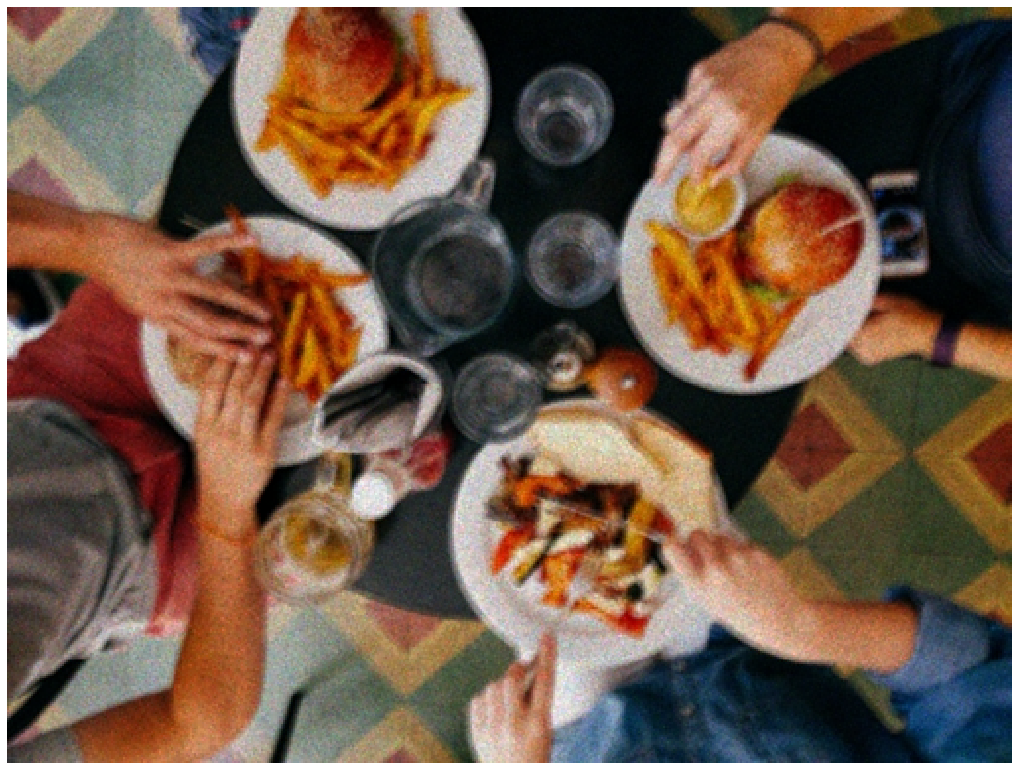

In [13]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


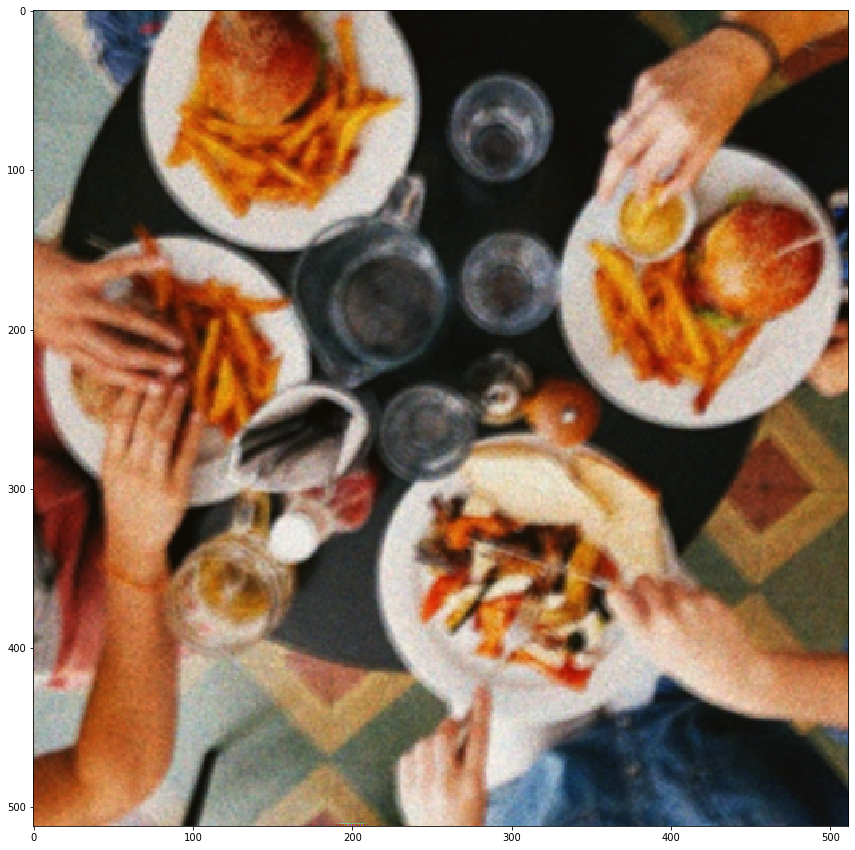

In [14]:
plt.figure(figsize = (18,15))
plt.imshow(img_hr.permute(1, 2, 0), interpolation='nearest')

In [28]:
img.data.shape

torch.Size([3, 384, 510])

In [29]:
img_hr.shape

torch.Size([3, 512, 512])

In [26]:
ssim = SSIM()
ssim(img_hr[None], img.data[None])

RuntimeError: The size of tensor a (502) must match the size of tensor b (500) at non-singleton dimension 3